## CAS739 Workshop 4: Genetic Programming in Reinforcement Learning

Reinforcement Learning (RL) is a machine learning problem in which an agent must learn how to map situations to actions in an unknown world in order to maximise the sum of future rewards. There are no labelled examples
of situation->action mappings to learn from and we assume that no model of environment dynamics is available. As such, learning requires active trial-and-error interaction with the world.

To apply genetic programming in RL, an outer search loop acts on a "genome" of code and an inner loop evaluates its ability to predict actions in the environment. We now have adaptation at two timescales: the *evolution* of a population and the *lifetime learning* of each individual:

<br>
<div>
<img src="attachment:EvoRL-2023-09-11.jpg" width="600"/>
</div>
<br>

(image above may not display in vscode or colab)

We'll use [DEAP](https://deap.readthedocs.io/en/master/) (Distributed Evolutionary Algorithms in Python) for the GP implementation.


In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install multiprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


For benchmark problems we'll use [gymnasium](https://gymnasium.farama.org/index.html), a popular RL API with a diverse collection of environments. We will experiment with the [classic control](https://gymnasium.farama.org/environments/classic_control/) tasks.

In [3]:
!pip install gymnasium[classic-control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.0 MB/s eta 0:00:00


In [4]:
!pip install pygame

In [5]:
import numpy
import random
import gymnasium as gym
import operator
import matplotlib.pyplot as plt
import math
from operator import attrgetter

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import multiprocessing

An important aspect of a GP experiment is the choice of the primitives set. They should make good building blocks for the individuals so the evolution can succeed. We start with a few custom functions, followed by basic arithmetic operators. See the [DEAP GP examples](https://deap.readthedocs.io/en/master/examples/index.html#genetic-programming-gp) for more details.

In [6]:
def protectedDiv(left, right):
    try: return truncate(left, 8) / truncate(right, 8)
    except ZeroDivisionError: return 0

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def limit(input, minimum, maximum):
    return min(max(input,minimum), maximum)

# Helper function to limit decimal places
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.modf(number)[1]
    factor = 10.0 ** decimals
    return math.modf(number * factor)[1] / factor

In [7]:
# Set up primitives and terminals using DEAP syntax
obs_size = 4 # CartPole-v1 has 4 variables in each observation (change for other tasks)
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(limit, 3)

We're going to start with the CartPole problem, which is basically the "hello world" of RL. Please review the [Cartpole documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/) before proceeding. We create two versions of the environment, one for evaluations during evolution and one with rendering enabled, which we use at the end to vizualize the best policy.

In [8]:
env_noviz = gym.make("CartPole-v1")
env_viz = gym.make("CartPole-v1", render_mode="human")

CartPole is a "bang-bang" control problem, meaning the policy has two discrete actions: it can either apply force in the left or right direction on the cart. Therefore, we need to discretize the output of our expression trees with a wrapper function.

In [9]:
def action_wrapper(action):
    if action < 0:
        return 0 #left force
    else:
        return 1 #right force

The evalRL function demonstrates the gymnasium API for evaluating the fitness of a RL policy. Note that fitness is the mean cumulative reward over 20 episodes. Each episode begins with unique initial conditions of the environment and ends when the policy fails, succeeds, or times out (e.g. [CartPole Episode End](https://gymnasium.farama.org/environments/classic_control/cart_pole/#episode-end)). We average a policy's fitness over multiple episodes to ensure it doesn't over fit to a particular initial condition.

In [10]:
# Evaluates the fitness of an individual policy
def evalRL(policy, vizualize=False):
    env = env_viz if vizualize else env_noviz
    num_episode = 1 if vizualize else 20
    # transform expression tree to functional Python code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for x in range(0, num_episode):
        done = False
        truncated = False
        # reset environment and get first observation
        observation = env.reset()
        observation = observation[0]
        episode_reward = 0
        num_steps = 0
        # evaluation episode
        while not (done or truncated):
            # use the expression tree to compute action
            action = get_action(observation[0], observation[1], observation[2], observation[3])
            action = action_wrapper(action)
            try:
                observation, reward, done, truncated, info = env.step(action)
            except:
                return (0,)
            episode_reward += reward
            num_steps += 1
        fitness += episode_reward
    if vizualize:
        env.close()
    return (fitness / num_episode,)

The following cell sets up various properties of the GP experiment in DEAP-specific syntax. See [docs](https://deap.readthedocs.io/en/master/) for details.

In [11]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Finally, we run the GP experiment. Running evaluations in parallel *really* speeds up the search, so take advantage of the num_parallel_evals parameter if your machine has multiple cores.

In [12]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 24
num_generations = 50
prob_xover = 0.9
prob_mutate = 0.1

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max  	min	nevals	std    	avg    	gen	max	min	nevals	std   
0  	24    	30.9542	0  	87.45	9.2	24    	23.6984	11.8333	0  	24 	4  	24    	5.8642
1  	22    	52.2271	1  	200.9	9.2	22    	43.2449	12.75  	1  	33 	5  	22    	7.13705
2  	24    	69.5375	2  	282.1	9.35	24    	75.8346	13.2083	2  	32 	3  	24    	9.08286
3  	24    	111.25 	3  	492.55	9.25	24    	119.354	15.8333	3  	30 	3  	24    	7.96171
4  	20    	148.852	4  	492.45	9.9 	20    	118.788	18.9583	4  	31 	3  	20    	8.48763
5  	20    	202.915	5  	492.45	37.65	20    	127.67 	17.7083	5  	29 	3  	20    	8.15209
6  	18    	239.881	6  	470.25	12.4 	18    	132.602	18.5833	6  	40 	8  	18    	8.30621
7  	22    	324.985	7  	500   	16.05	22    	128.343	17     	7  	39 	3  	22    	8.77021
8  	24    	382.946	8  	500   

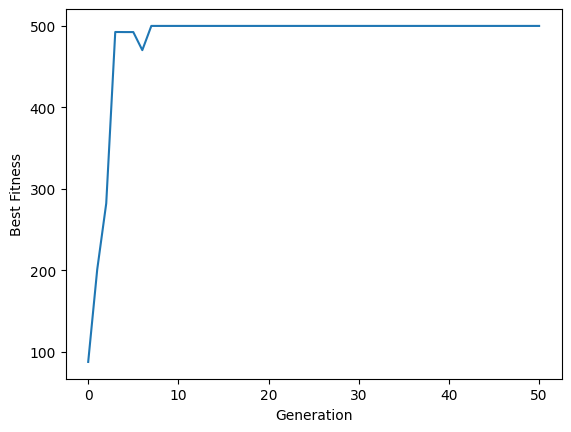

In [13]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

Most gymnasium environments come with support for visualizing policy behaviour. Let's see the behaviour of the best individual:

In [14]:
evalRL(policy=hof[0], vizualize=True)

(500.0,)

In [15]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [16]:
import pygraphviz

In [17]:
!pip install networkx

In [18]:
nodes, edges, labels = gp.graph(hof[0])

### Graphviz Section ###
import pygraphviz as pgv

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

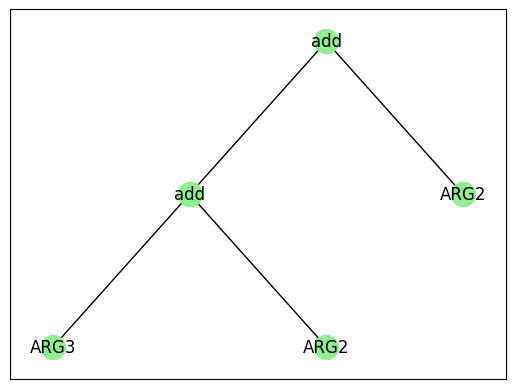

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos, node_color="lightgreen")
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
Try to evolve policies for the Acrobot and Pendulum tasks in [classic control](https://gymnasium.farama.org/environments/classic_control/). You may change anything about the GP setup including the primitives set, action wrapper, or EA parameters. Pay special attention to the size of the observation space and the nature of the actions for different task. For each task, your results should include a training curve, the fitness and size of the best tree, and a plot showing the best expression tree. You may have to search DEAP's documentation to see how to plot graphs.
</div>

## Pendulium

Now I'll optimize a policy for pendulium environment:

In [20]:
import numpy
import random
import gymnasium as gym
import operator
import matplotlib.pyplot as plt
import math
from operator import attrgetter

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import pygame
import multiprocessing

In [21]:
def protectedDiv(left, right):
    try: return truncate(left, 8) / truncate(right, 8)
    except ZeroDivisionError: return 0

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def limit(input, minimum, maximum):
    return min(max(input,minimum), maximum)

# Helper function to limit decimal places
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.modf(number)[1]
    factor = 10.0 ** decimals
    return math.modf(number * factor)[1] / factor

def square(input):
    return (input**2)

In [22]:
# Set up primitives and terminals using DEAP syntax
obs_size = 3 # Pendulium has 3 variables in each observation (change for other tasks)
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(square, 1)
pset.addPrimitive(limit, 3)

In [23]:
pygame.init()
env_noviz = gym.make("Pendulum-v1")
env_viz = gym.make("Pendulum-v1", render_mode="human")

In [24]:
def action_wrapper(action):
    # Limit the action to the environment's action range (typically -2 to +2)
    return numpy.clip(action, env_noviz.action_space.low[0], env_noviz.action_space.high[0])


In [25]:
# Evaluates the fitness of an individual policy
def evalRL(policy, visualize=False):
    env = env_viz if visualize else env_noviz
    num_episode = 1 if visualize else 20
    # Transform expression tree to functional Python code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for _ in range(num_episode):
        done = False
        truncated = False
        # Reset environment and get the first observation
        observation = env.reset()
        observation = observation[0]  # Observation is a tuple in the new Gym API
        episode_reward = 0
        # Evaluation episode
        while not (done or truncated):
            # Use the expression tree to compute action based on 3 observation values
            action = get_action(observation[0], observation[1], observation[2],)
            action = action_wrapper(action)
            try:
                observation, reward, done, truncated, info = env.step([action])  # Action as list for compatibility
            except:
                return (0,)
            episode_reward += reward
        fitness += episode_reward
    if visualize:
        env.close()
    # Average reward over episodes for fitness evaluation
    return (fitness / num_episode,)

In [26]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [27]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 50
num_generations = 200
prob_xover = 0.8
prob_mutate = 0.2

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                            fitness                            	                      size                     
   	      	---------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max    	min     	nevals	std    	avg 	gen	max	min	nevals	std    
0  	50    	-1327.34	0  	-990.75	-1692.61	50    	152.109	11.1	0  	37 	3  	50    	8.34326
1  	40    	-1283.09	1  	-871.083	-1618.55	40    	143.297	10.42	1  	29 	2  	40    	7.59234
2  	40    	-1284.01	2  	-1065.8 	-1858.15	40    	127.86 	10.62	2  	30 	1  	40    	8.42589
3  	44    	-1259.66	3  	-986.111	-1883.57	44    	163.52 	13.16	3  	33 	2  	44    	9.50444
4  	38    	-1251.16	4  	-947.886	-1833.26	38    	146.536	14.5 	4  	31 	2  	38    	9.04489
5  	41    	-1210.74	5  	-947.886	-1401.74	41    	111.951	15.5 	5  	47 	2  	41    	8.88651
6  	44    	-1245.88	6  	-893.866	-1784.55	44    	170.987	16.14	6  	37 	1  	44    	9.58334
7  	46    	-1213.95	7  	-842.217	-1537

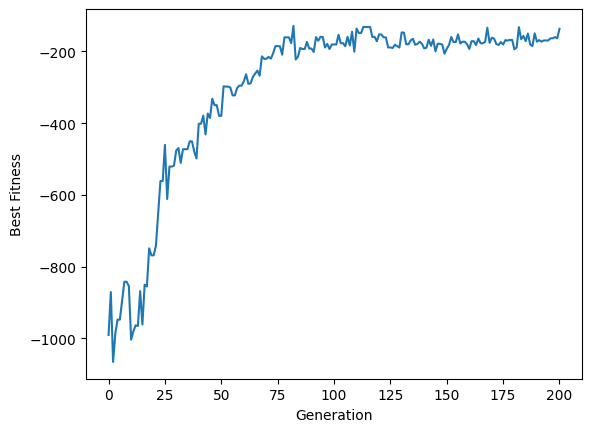

In [28]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [29]:
evalRL(policy=hof[0], visualize=True)

(-16.540312180281493,)

The policy tree with the best performance is:

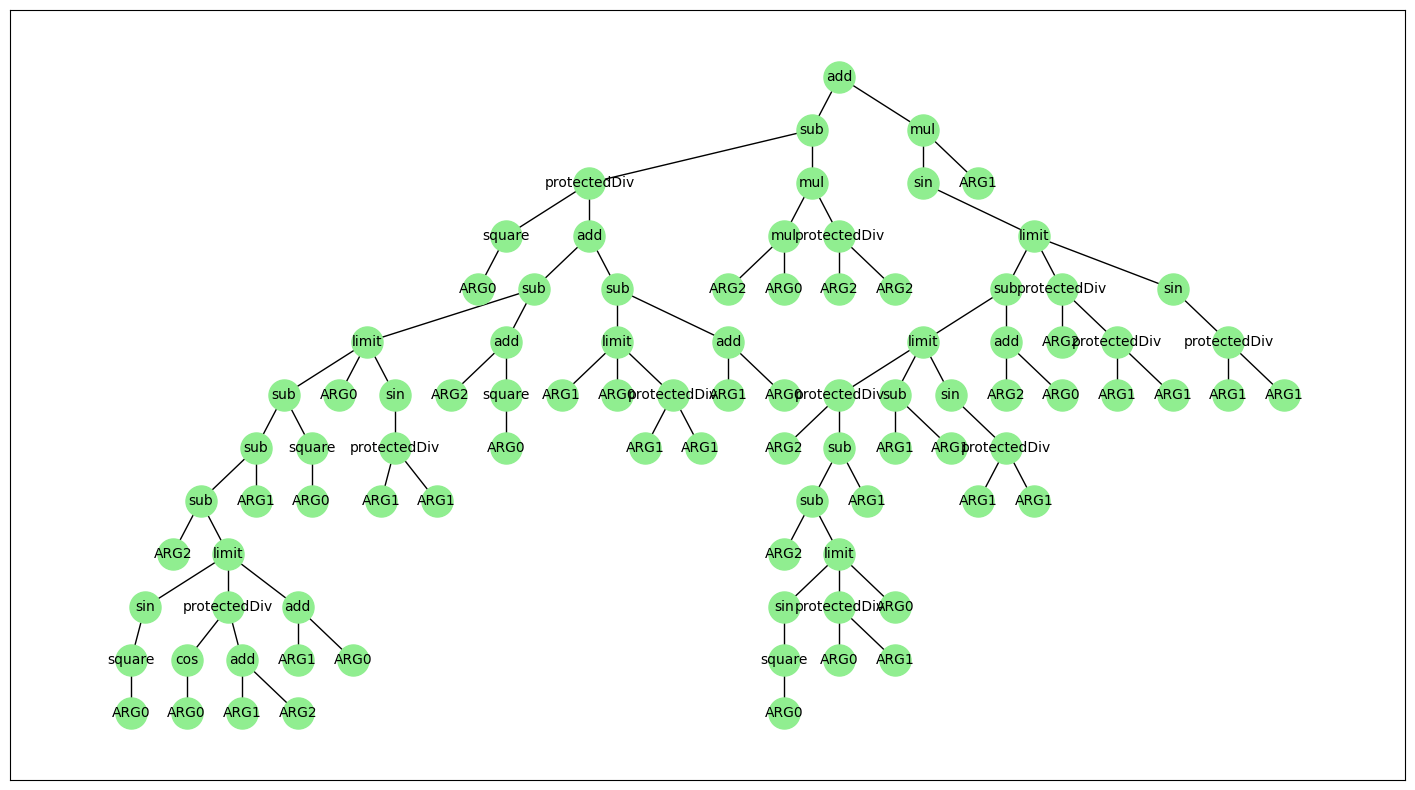

In [30]:
nodes, edges, labels = gp.graph(hof[0])

### Graphviz Section ###
import pygraphviz as pgv

# Create and configure the AGraph for saving as PDF with additional spacing
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.graph_attr.update(ranksep="1", nodesep="0.5")  # Adjust rank and node separation
g.layout(prog="dot")

# Set labels for each node
for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

import matplotlib.pyplot as plt
import networkx as nx

# Configure and draw with NetworkX for visualization
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

plt.figure(figsize=(18, 10))  # Increase figure size to allow more spacing
nx.draw_networkx_nodes(g, pos, node_color="lightgreen", node_size=500)  # Larger node size for visibility
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels, font_size=10)  # Set font size for clarity
plt.show()

## Acrobat

In this section I'll optimize policies for acrobat environment:

In [31]:
import numpy
import random
import gymnasium as gym
import operator
import matplotlib.pyplot as plt
import math
from operator import attrgetter

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
import pygame


In [32]:
def protectedDiv(left, right):
    try: return truncate(left, 8) / truncate(right, 8)
    except ZeroDivisionError: return 0

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def limit(input, minimum, maximum):
    return min(max(input,minimum), maximum)

# Helper function to limit decimal places
def truncate(number, decimals=0):
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.modf(number)[1]
    factor = 10.0 ** decimals
    return math.modf(number * factor)[1] / factor

def square(input):
    return (input**2)

In [33]:
# Set up primitives and terminals using DEAP syntax
obs_size = 6 # Acrobat has 6 variables in each observation (change for other tasks)
pset = gp.PrimitiveSet("MAIN", obs_size)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(square, 1)
pset.addPrimitive(limit, 3)

In [34]:
pygame.init()
env_noviz = gym.make("Acrobot-v1")
env_viz = gym.make("Acrobot-v1", render_mode="human")

In [35]:
# Action wrapper for Acrobot with 3 discrete torque levels (-1, 0, 1)
def action_wrapper(action):
    if action <= -1:
        return 0  # apply -1 torque
    elif action >= 1:
        return 2  # apply +1 torque
    else:
        return 1  # apply 0 torque

In [36]:
# Evaluates the fitness of an individual policy
def evalRL(policy, visualize=False):
    env = env_viz if visualize else env_noviz
    num_episode = 1 if visualize else 20
    # Transform expression tree to functional Python code
    get_action = gp.compile(policy, pset)
    fitness = 0
    for _ in range(num_episode):
        done = False
        truncated = False
        # Reset environment and get the first observation
        observation = env.reset()
        observation = observation[0]  # Observation is a tuple in the new Gym API
        episode_reward = 0
        num_steps = 0
        # Evaluation episode
        while not (done or truncated):
            # Use the expression tree to compute action based on 6 observation values
            action = get_action(
                observation[0], observation[1], observation[2],
                observation[3], observation[4], observation[5]
            )
            action = action_wrapper(action)
            try:
                observation, reward, done, truncated, info = env.step(action)
            except:
                return (0,)
            episode_reward += reward
            num_steps += 1
        fitness += episode_reward
    if visualize:
        env.close()
    # Average reward over episodes for fitness evaluation
    return (fitness / num_episode,)

In [37]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalRL)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [38]:
random.seed(42)
# set to the number of cpu cores available
num_parallel_evals = 4

population_size = 50
num_generations = 100
prob_xover = 0.8
prob_mutate = 0.2

pop = toolbox.population(n=population_size)

# HallOfFame archives the best individuals found so far,
# even if they are deleted from the population.
hof = tools.HallOfFame(1)  # We keep the single best.

# configues what stats we want to track
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

#setup parallel evaluations
pool = multiprocessing.Pool(processes=num_parallel_evals)
toolbox.register("map", pool.map)

# run the evolutionary algorithm
pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    prob_xover,
    prob_mutate,
    num_generations,
    stats=mstats,
    halloffame=hof,
    verbose=True
)

pool.close()

best_fits = log.chapters["fitness"].select("max")
best_fit = truncate(hof[0].fitness.values[0], 0)

print("Best fitness: " + str(best_fit))
print(hof[0])

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max    	min 	nevals	std    	avg 	gen	max	min	nevals	std    
0  	50    	-486.901	0  	-109.55	-500	50    	65.3961	8.66	0  	24 	3  	50    	4.66738
1  	45    	-470.764	1  	-91.1  	-500	45    	98.8653	8.8 	1  	24 	1  	45    	4.6    
2  	44    	-445.867	2  	-76.55 	-500	44    	130.906	10.54	2  	28 	2  	44    	5.41188
3  	41    	-382.417	3  	-76.55 	-500	41    	172.393	10.46	3  	28 	2  	41    	5.24675
4  	38    	-344.663	4  	-82.9  	-500	38    	180.134	11.4 	4  	25 	3  	38    	5.52811
5  	40    	-268.024	5  	-80.7  	-500	40    	188.788	15   	5  	27 	3  	40    	5.92959
6  	46    	-288.923	6  	-77.8  	-500	46    	188.605	15.14	6  	35 	3  	46    	6.32775
7  	41    	-251.024	7  	-79.2  	-500	41    	187.474	15.64	7  	36 	2  	41    	8.03184
8  	47  

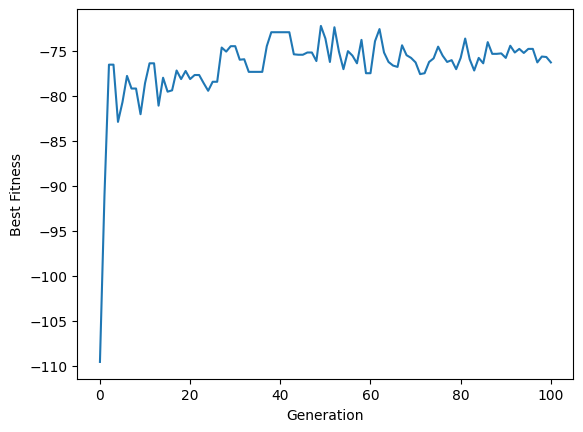

In [39]:
plt.plot(best_fits)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [40]:
evalRL(policy=hof[0], visualize=True)

(-82.0,)

The policy tree with the best performance is:

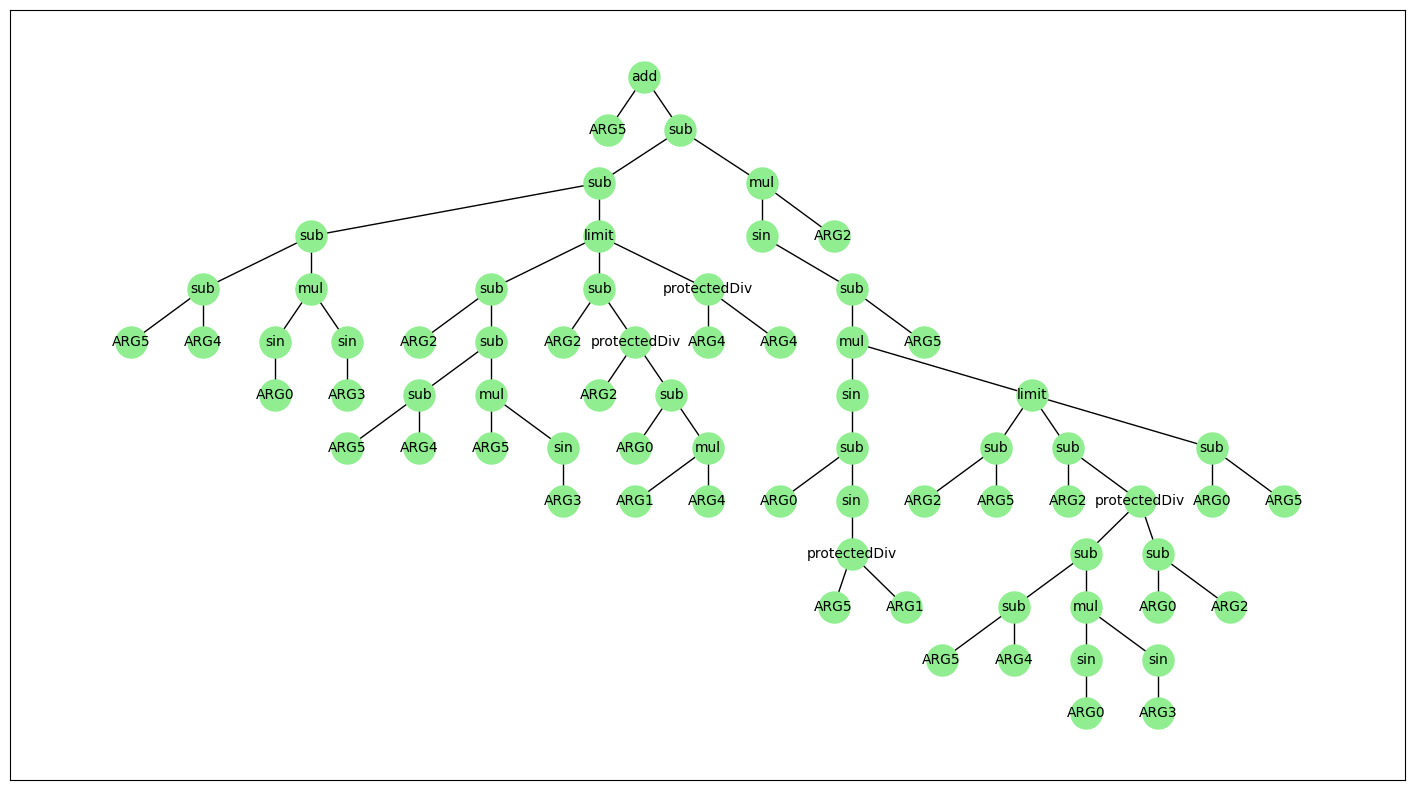

In [41]:
nodes, edges, labels = gp.graph(hof[0])

### Graphviz Section ###
import pygraphviz as pgv

# Create and configure the AGraph for saving as PDF with additional spacing
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.graph_attr.update(ranksep="1", nodesep="0.5")  # Adjust rank and node separation
g.layout(prog="dot")

# Set labels for each node
for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

import matplotlib.pyplot as plt
import networkx as nx

# Configure and draw with NetworkX for visualization
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

plt.figure(figsize=(18, 10))  # Increase figure size to allow more spacing
nx.draw_networkx_nodes(g, pos, node_color="lightgreen", node_size=500)  # Larger node size for visibility
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels, font_size=10)  # Set font size for clarity
plt.show()